In [21]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import resample

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import yfinance as yf

In [22]:
# object = yf.Ticker('JWN')
# data = object.history(start="2000-01-01", end="2020-11-17")
# data.to_csv('Data/nordstrom.csv')
data = pd.read_csv('Data/nordstrom.csv', index_col='Date')

In [23]:
# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

In [24]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [25]:
# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]     

    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

In [26]:
def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")

In [27]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [28]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50,neuronsLSTM2=128, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

In [29]:
# model = modelTraining(2000, 10)
# saveModel(model, "fordRealComplete", location='Data')
model = loadModel(name="nordstromComplete")

MSE Train: 0.534805262810811
MSE Test: 1.4801148246212157


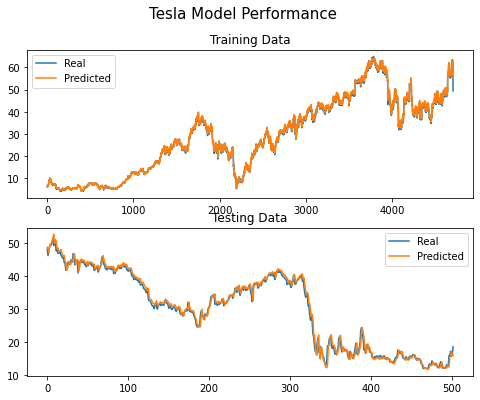

In [30]:
mseTrain, yHat, y = mse(xTrain,yTrain)
print("MSE Train:", mseTrain)

fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Tesla Model Performance', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])


mseTest, yHat, y = mse(xTest,yTest)

print("MSE Test:", mseTest)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

In [31]:
def formulateData(originalData, residuals, predicted):
    originalData = pd.DataFrame(originalData['Open'])

    originalData['residuals'] = residuals
    originalData['predicted'] = predicted

    originalData['tomorrow'] = originalData['predicted'].shift(-1)

    originalData['action'] = np.where(originalData['tomorrow'] - originalData['Open'] > 0, 'buy', 'sell')

    return originalData

def prediction(scaler, model, x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return (preds-unscaled_yTest), preds, unscaled_yTest

data = pd.DataFrame(data, index=pd.to_datetime(data.index))
dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
fordTrain = data[data.index < dt].iloc[40:,:]
fordTest = data[data.index >= dt]
residuals, yHat, y = prediction(scaler, model, xTest, yTest)
tradingActionsTest = formulateData(fordTest, residuals, yHat)

residuals, yHat, y = prediction(scaler, model, xTrain, yTrain)
tradingActionsTrain = formulateData(fordTrain, residuals, yHat)

In [32]:
lookBack = 180
tradingActionsTest_full = pd.concat([tradingActionsTrain.iloc[-lookBack:,],tradingActionsTest])
movingResidualAvg = []
for i in range(lookBack, len(tradingActionsTest_full)):
    residualAverage = np.average(tradingActionsTest_full.iloc[i-lookBack:i,:]['residuals'])
    movingResidualAvg.append(residualAverage )

tradingActionsTest['movingResidual'] = movingResidualAvg
tradingActionsTest['predictedResidualTomorrow'] = tradingActionsTest['tomorrow'] - tradingActionsTest['movingResidual']
tradingActionsTest['residualAction'] = np.where(tradingActionsTest['predictedResidualTomorrow'] - tradingActionsTest['Open']>0,
                                                'buy',
                                                'sell')

In [33]:
tradingActionsTest['trueTomorrow'] = tradingActionsTest['Open'].shift(-1)
tradingActionsTest['trueAction'] = np.where(tradingActionsTest['trueTomorrow']-tradingActionsTest['Open']>0,
                                           'buy',
                                           'sell')

In [34]:
print(np.sum(tradingActionsTest['residualAction'] ==   tradingActionsTest['trueAction'])/len(tradingActionsTest))

0.5517928286852589


In [35]:
tradingActionsFinal = tradingActionsTest[['Open', 'trueTomorrow', 'predictedResidualTomorrow','residualAction']]
tradingActionsFinal = tradingActionsFinal.rename(columns={'predictedResidualTomorrow':'predictedTomorrow','residualAction':'predictedAction'})
tradingActionsFinal['predicted'] = tradingActionsFinal['predictedTomorrow'].shift(1)
tradingActionsFinal['residual'] = tradingActionsFinal['predicted']-tradingActionsFinal['Open']
tradingActionsFinal['stock'] = 'nordstrom'

In [36]:
tradingActionsFinal.to_csv('Data/nordstromComplete.csv')

In [18]:
tradingActionsFinal

,Open,trueTomorrow,predictedTomorrow,predictedAction,predicted,residual,stock
Date,,,,,,,
2018-11-19,48.102972,46.139388,47.899757,sell,NaN,NaN,normstrom
2018-11-20,46.139388,48.084176,46.663054,buy,47.899757,1.760369,normstrom
2018-11-21,48.084176,48.899676,48.342398,buy,46.663054,-1.421122,normstrom
2018-11-23,48.899676,49.126763,49.214996,buy,48.342398,-0.557278,normstrom
2018-11-26,49.126763,49.476864,49.525131,buy,49.214996,0.088233,normstrom
...,...,...,...,...,...,...,...
2020-11-10,16.049999,17.290001,15.893317,sell,15.268183,-0.781817,normstrom
2020-11-11,17.290001,15.710000,17.162676,sell,15.893317,-1.396684,normstrom
2020-11-12,15.710000,16.040001,15.845409,buy,17.162676,1.452676,normstrom
